### Load module

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import copy
plt.rc('text', usetex=True)

### define functions

In [2]:
def detect_files(directory, keyword):
    """
    detect files in specified directory with specified keyword

    input
    -----
    directory : string
        dir to search

    keyword : string
        keyword to look for

    output
    -----
    sorted list of file names

    test
    -----
        (1) if output has larger than length;
    """

    file_list = []
    for file in os.listdir(directory):
        if not (keyword is None):
            if keyword in file:
                file_list.append(file)
        else:
            file_list.append(file)
    
    return sorted(file_list)

def read_files(directory, keyword):
    """
    read files with specified keyword

    input
    -----
    directory : string
        directory to read files from

    keyword : string
        keyword to search for

    output
    -----
    output_dic : dic
        dictionary of datasets

    test
    -----
        (1) output_dic should have length 5, for 2013 - 2017;
        (2) keyword should not be empty;
    """
    output_dic = {}
    file_list = detect_files(directory, keyword)
    for yr in range(2013, 2018):
        output_dic[yr] = pd.read_csv(os.path.join(directory, file_list[yr-2013]))
    return output_dic

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

def two_scales(ax1, time, data1, data2, data3, c1, c2, c3):
    ax2 = ax1.twinx()
    p1 = ax1.bar(time, data1, width=0.5, color=c1)
    p2 = ax1.bar(time, data2, width=0.5, bottom=data1, color=c2)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Num. of cases')
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    p3 = ax2.plot(time, data3, color=c3, linewidth=3)
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    color_y_axis(ax2, 'b')
    ax2.annotate("", xy=(2017.4, data3[-1]*0.98), xytext=(2017, data3[-1]*0.98),
                 arrowprops=dict(width=1, headwidth=8, headlength=8))
    # ax2.set_ylabel('Fatal')
    return ax1, ax2

def two_scales_with_legend(ax1, time, data1, data2, data3, c1, c2, c3):
    ax2 = ax1.twinx()
    p1 = ax1.bar(time, data1, width=0.5, color=c1, label='INJ')
    p2 = ax1.bar(time, data2, width=0.5, bottom=data1, color=c2, label='PDO')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Num. of cases')
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    p3 = ax2.plot(time, data3, color=c3, linewidth=3, label='FAT')
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    color_y_axis(ax2, 'b')
    ax2.annotate("", xy=(2017.4, data3[-1]*0.98), xytext=(2017, data3[-1]*0.98),
                 arrowprops=dict(width=1, headwidth=8, headlength=8))
    # ax2.set_ylabel('Fatal')
    return ax1, ax2


### general

#### read the crash files

In [3]:
crash = read_files("./hsis-csv", 'acc')

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (9,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


#### regroup and count

In [4]:
combine_map = {
    1:11,
    2:12,
    3:13,
    4:14,
    5:15,
    6:16,
    7:17,

    # other multi 29
    27:29,
    28:29,
    
    71:77,# Peds and cyclist
    72:77,
    73:77,
    74:77,
    75:77,
    76:77,
    
    # single vehicle 99
    32:99,
    33:99,
    34:99,
    35:99,
    40:99,
    41:99,
    50:99,
    54:99,
    60:99,
    61:99,
    62:99,
    88:99,
    98:99
    
}
acc_by_type = {}
for year in range(2013, 2018):
    df = crash[year]
    acc_by_type[year] = df.ACCTYPE.replace(combine_map).value_counts().sort_index().to_frame()
    acc_by_type[year].columns = ['cnt']
    df = df[['ACCTYPE', 'REPORT']]
    df.ACCTYPE = df.ACCTYPE.replace(combine_map)
    acc_by_type[year] = acc_by_type[year].merge(
        df.groupby(['ACCTYPE', 'REPORT']).size().unstack().fillna(0).astype(int),
        left_index=True, right_index=True)
    columns = ['cnt', 'PDO', 'INJ', 'FAT']
    acc_by_type[year].columns = columns

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### plot for each year

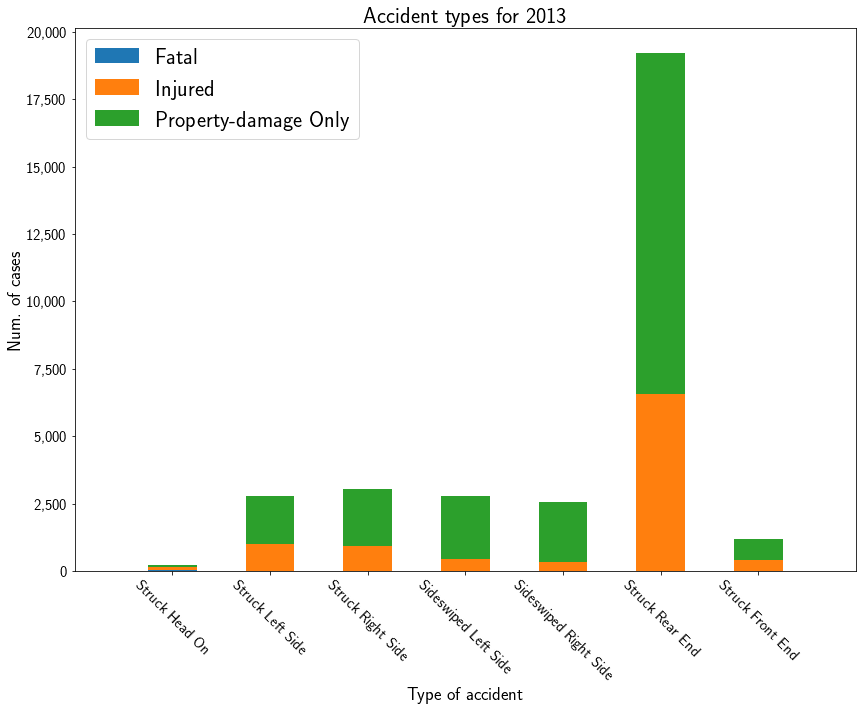

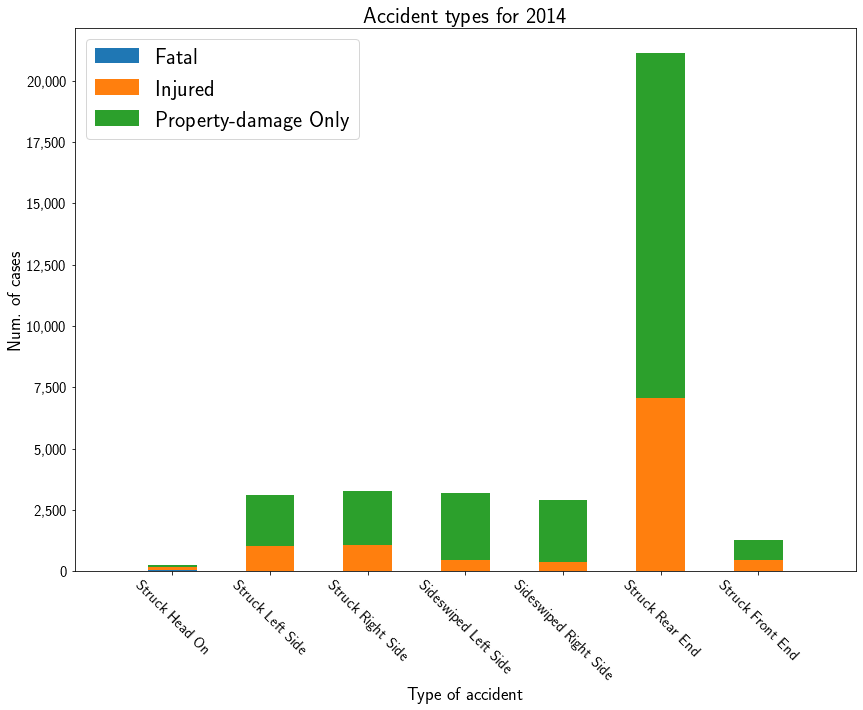

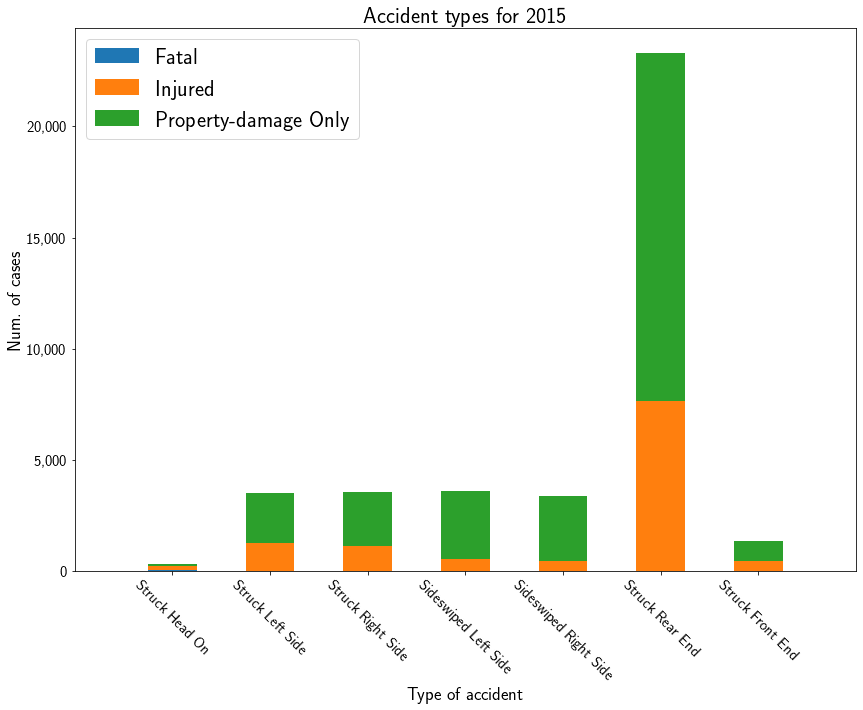

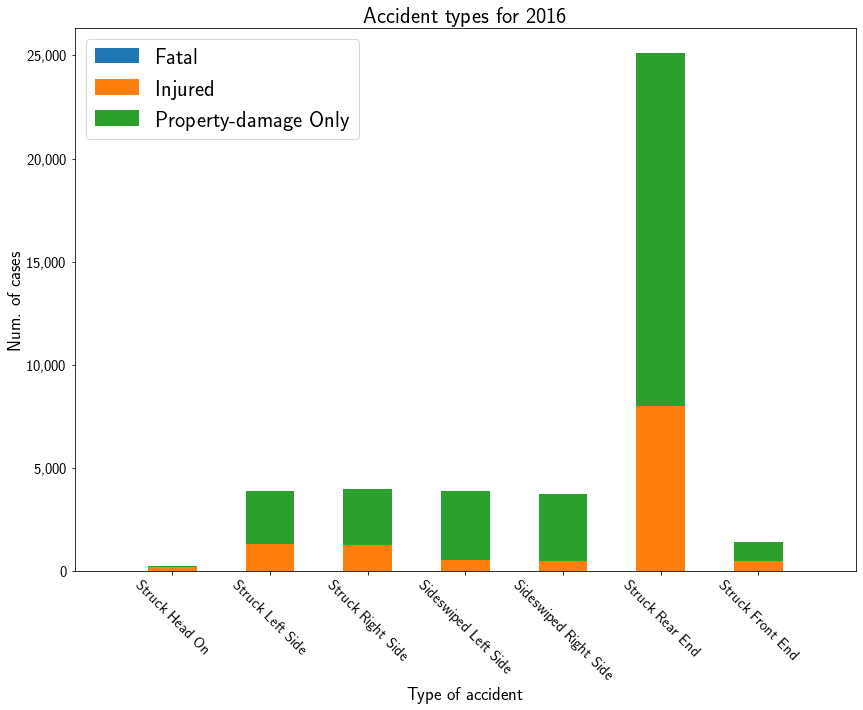

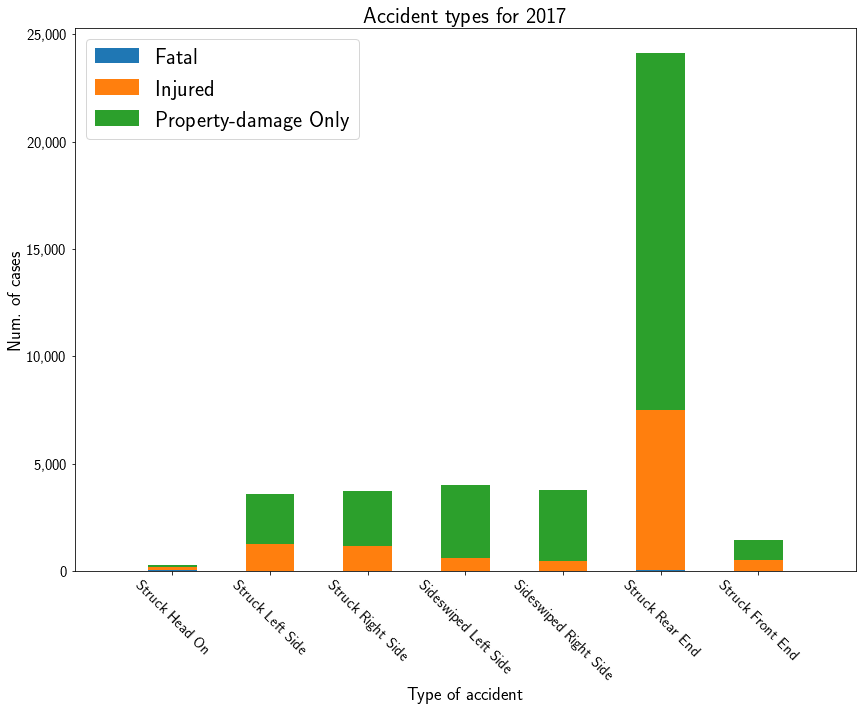

In [8]:
acc_type_list = [
    r'Struck Head On', r'Struck Left Side', r'Struck Right Side', r'Sideswiped Left Side', r'Sideswiped Right Side',
    r'Struck Rear End', r'Struck Front End', r'Other Multi', r'Peds \& Cyclists', r'Other Single'
]
width = 0.5

cnt = 0
for year in range(2013, 2018):
    # plt.figure(cnt, dpi=180, facecolor='#F9E4B7', edgecolor='k')
    fig, ax = plt.subplots(figsize=(14,10))
    
    p1 = plt.bar(acc_by_type[year].index, list(acc_by_type[year].FAT), width)
    p2 = plt.bar(acc_by_type[year].index, list(acc_by_type[year].INJ), width, bottom=list(acc_by_type[year].FAT))
    p3 = plt.bar(acc_by_type[year].index, list(acc_by_type[year].PDO), width, bottom=list(acc_by_type[year].FAT+acc_by_type[year].INJ))
    plt.xticks(acc_by_type[year].index, acc_type_list,rotation=-45)
    plt.xlim(10,18)
    # plt.ylim(0,500)
    ax.set_xlabel(r'Type of accident', fontsize=18)
    ax.set_ylabel(r'Num. of cases', fontsize=18)
    ax.tick_params(labelsize=15)
    plt.title(r'Accident types for {}'.format(year), fontsize=22)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend((p1[0], p2[0], p3[0]), ('Fatal', 'Injured', 'Property-damage Only'), fontsize=22)
    cnt += 1

plt.show()

#### plot for each type across years

In [6]:
acc_type_list = [
    r'Struck Head On', r'Struck Left Side', r'Struck Right Side', r'Sideswiped Left Side', r'Sideswiped Right Side',
    r'Struck Rear End', r'Struck Front End', r'Other Multi', r'Peds \& Cyclists', r'Other Single'
]
acc_type_index_list = [11, 12, 13, 14, 15, 16, 17, 29, 77, 99]
width = 0.5

fat = [acc_by_type[year].FAT for year in range(2013, 2018)]
inj = [acc_by_type[year].INJ for year in range(2013, 2018)]
pdo = [acc_by_type[year].PDO for year in range(2013, 2018)]


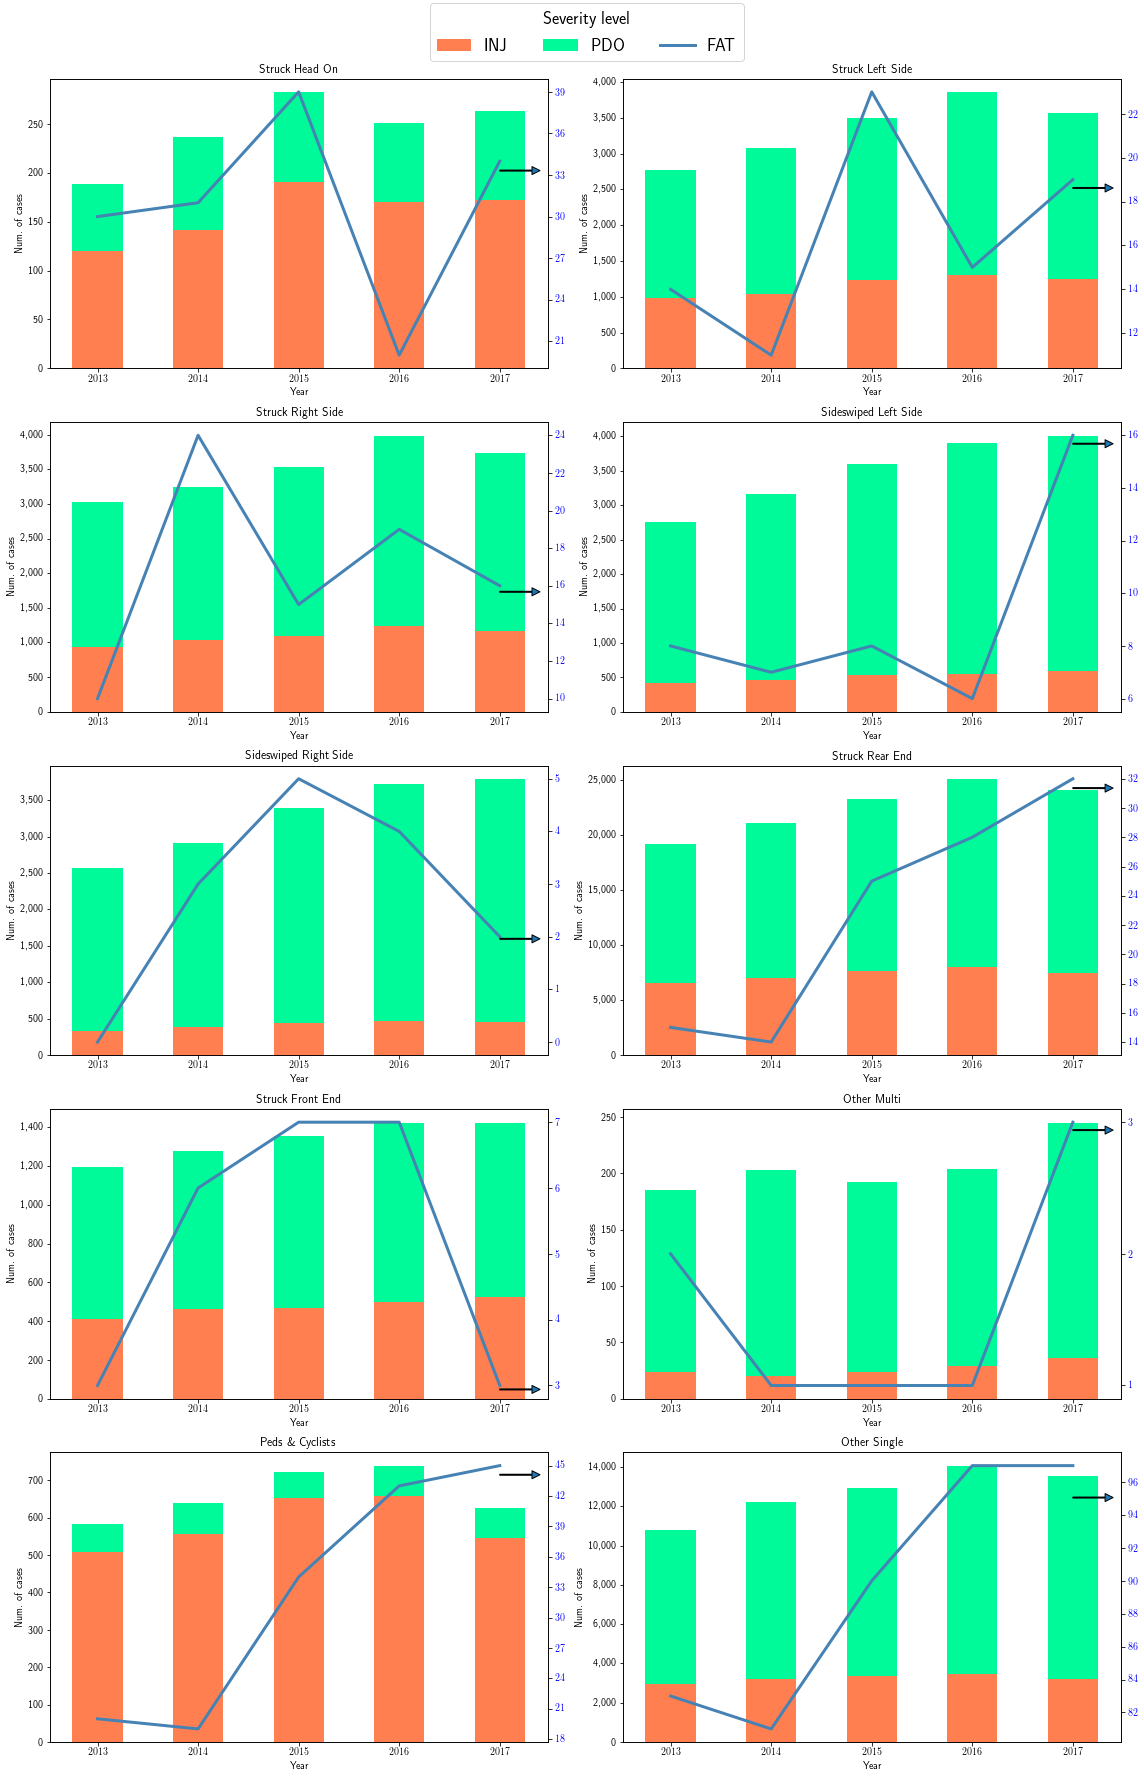

In [7]:
fig, axes = plt.subplots(5,2, figsize=(16,24))

nyear = 5
t = range(2013, 2013 + nyear)
for ind in range(len(acc_type_list) - 1): # 0,10
    s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    ax1, _ = two_scales(axes[ind//2][ind%2], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
    ax1.set_title('{}'.format(acc_type_list[ind]))

ind += 1
s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
ax1, _ = two_scales_with_legend(axes[ind//2][ind%2], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
ax1.set_title('{}'.format(acc_type_list[ind]))

fig.legend(
           # loc="upper center",   # Position of legend
           borderaxespad=0.3,    # Small spacing around legend box
           ncol=4,
           bbox_to_anchor=(0.65,1.03), 
           title="Severity level",  # Title for the legend
           fontsize="xx-large",title_fontsize="xx-large"
           )
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# plt.subplots_adjust(top = 0.8)
plt.tight_layout()
plt.show()

#### plot for all years

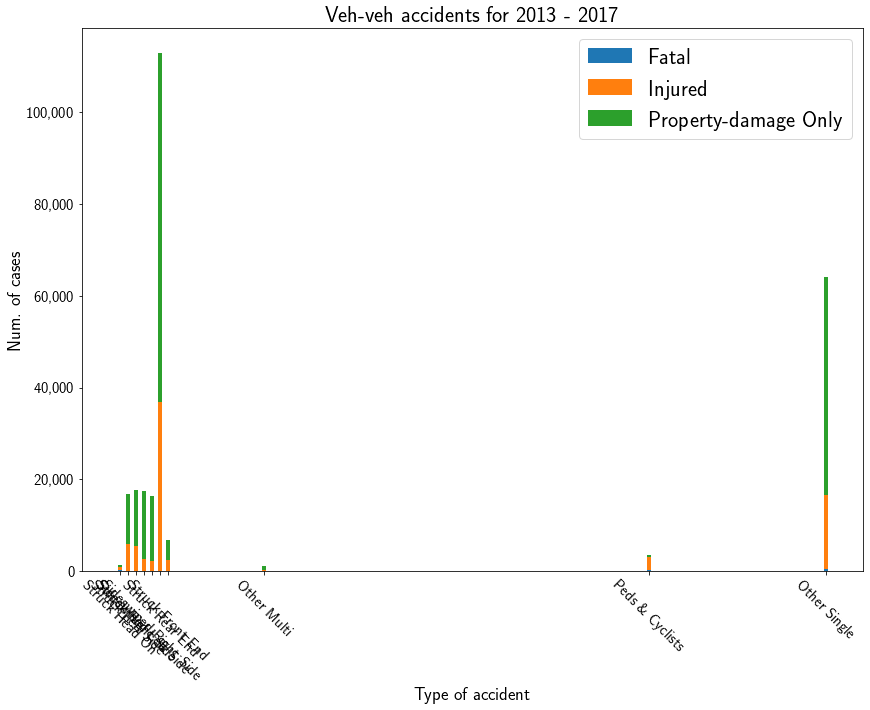

In [9]:
big_df = acc_by_type[2013] + acc_by_type[2014] + acc_by_type[2015] + acc_by_type[2016] + acc_by_type[2017]

fig, ax = plt.subplots(figsize=(14,10))

p1 = plt.bar(big_df.index, list(big_df.FAT), width)
p2 = plt.bar(big_df.index, list(big_df.INJ), width, bottom=list(big_df.FAT))
p3 = plt.bar(big_df.index, list(big_df.PDO), width, bottom=list(big_df.FAT+big_df.INJ))
plt.xticks(big_df.index, acc_type_list,rotation=-45)
# plt.xlim(10,18)
# plt.ylim(0,500)
ax.set_xlabel(r'Type of accident', fontsize=18)
ax.set_ylabel(r'Num. of cases', fontsize=18)
ax.tick_params(labelsize=15)
plt.title(r'Veh-veh accidents for 2013 - 2017', fontsize=22)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend((p1[0], p2[0], p3[0]), ('Fatal', 'Injured', 'Property-damage Only'), fontsize=22)
plt.show()

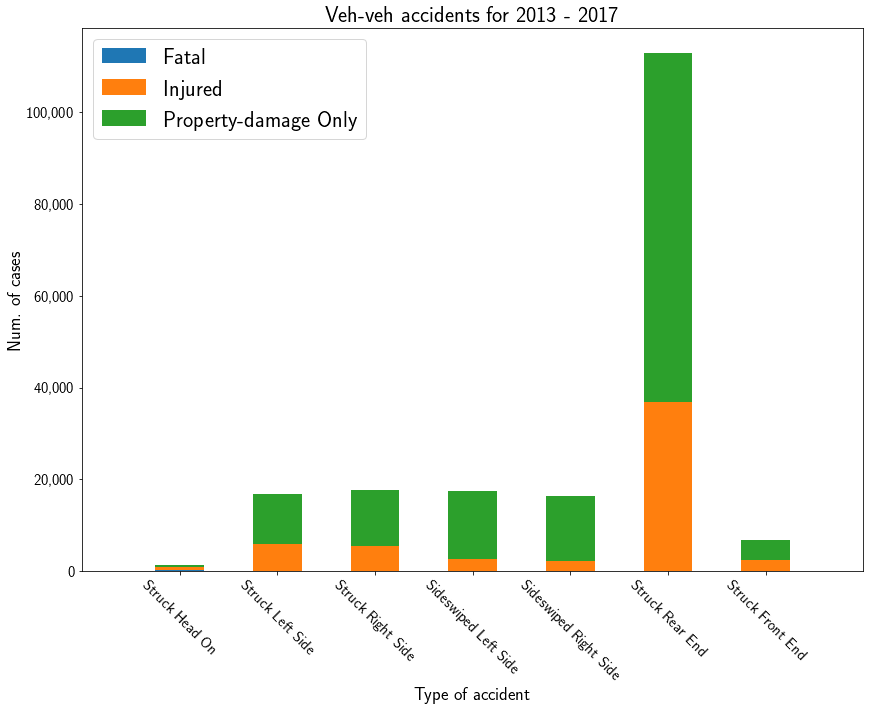

In [10]:
big_df = acc_by_type[2013] + acc_by_type[2014] + acc_by_type[2015] + acc_by_type[2016] + acc_by_type[2017]

fig, ax = plt.subplots(figsize=(14,10))

p1 = plt.bar(big_df.index, list(big_df.FAT), width)
p2 = plt.bar(big_df.index, list(big_df.INJ), width, bottom=list(big_df.FAT))
p3 = plt.bar(big_df.index, list(big_df.PDO), width, bottom=list(big_df.FAT+big_df.INJ))
plt.xticks(big_df.index, acc_type_list,rotation=-45)
plt.xlim(10,18)
# plt.ylim(0,20000)
ax.set_xlabel(r'Type of accident', fontsize=18)
ax.set_ylabel(r'Num. of cases', fontsize=18)
ax.tick_params(labelsize=15)
plt.title(r'Veh-veh accidents for 2013 - 2017', fontsize=22)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend((p1[0], p2[0], p3[0]), ('Fatal', 'Injured', 'Property-damage Only'), fontsize=22)
plt.show()

### Single veh acc

In [11]:
crash = read_files("./hsis-csv", 'acc')

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (9,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
for file in crash:
    print("Initial length for {} is {}".format(file, len(crash[file])))
    df = crash[file]
    df = df[df.ACCTYPE > 29]
    crash[file] = df

for file in crash:
    print("After length for {} is {}".format(file, len(crash[file])))

Initial length for 2013 is 43469
Initial length for 2014 is 48292
Initial length for 2015 is 53010
Initial length for 2016 is 57415
Initial length for 2017 is 55548
After length for 2013 is 11501
After length for 2014 is 12972
After length for 2015 is 13784
After length for 2016 is 14916
After length for 2017 is 14311


In [13]:
combine_map = {
    
    71:77,# Peds and cyclist
    72:77,
    73:77,
    74:77,
    75:77,
    76:77

}

acc_by_type = {}
for year in range(2013, 2018):
    df = crash[year]
    acc_by_type[year] = df.ACCTYPE.replace(combine_map).value_counts().sort_index().to_frame()
    acc_by_type[year].columns = ['cnt']
    df = df[['ACCTYPE', 'REPORT']]
    df.ACCTYPE = df.ACCTYPE.replace(combine_map)
    acc_by_type[year] = acc_by_type[year].merge(
        df.groupby(['ACCTYPE', 'REPORT']).size().unstack().fillna(0).astype(int),
        left_index=True, right_index=True)
    columns = ['cnt', 'PDO', 'INJ', 'FAT']
    acc_by_type[year].columns = columns

/Users/shuyiyin/anaconda/envs/syin/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
acc_type_list = [
    r'Strikes Animal or Bird', r'Strikes Appurtenance', r'Strikes Other Object', r'Strikes or Was Struck by Working Object', 
    r'Strikes Railroad Train', r'Was Struck by Railroad Train', r'Vehicle Overturned', r'Non-Collision Fire', 
    r'Ran into Roadway Ditch', r'Ran into River, Lake, etc.', r'Ran over Embankment – No Guardrail Present', r'Peds \& Cyclists',
    r'Pushed Vehicle Struck by Pushing Vehicle', r'Jackknife Trailer', r'Other'
]
acc_type_index_list = [32, 33, 34, 35, 40, 41, 50, 54, 60, 61, 62, 77, 88, 98, 99]
width = 0.5

fat = [acc_by_type[year].FAT for year in range(2013, 2018)]
inj = [acc_by_type[year].INJ for year in range(2013, 2018)]
pdo = [acc_by_type[year].PDO for year in range(2013, 2018)]


In [15]:
for item in acc_type_index_list:
    for df in fat:
        if item not in df.index:
            df.at[item] = 0
    for df in inj:
        if item not in df.index:
            df.at[item] = 0
    for df in pdo:
        if item not in df.index:
            df.at[item] = 0

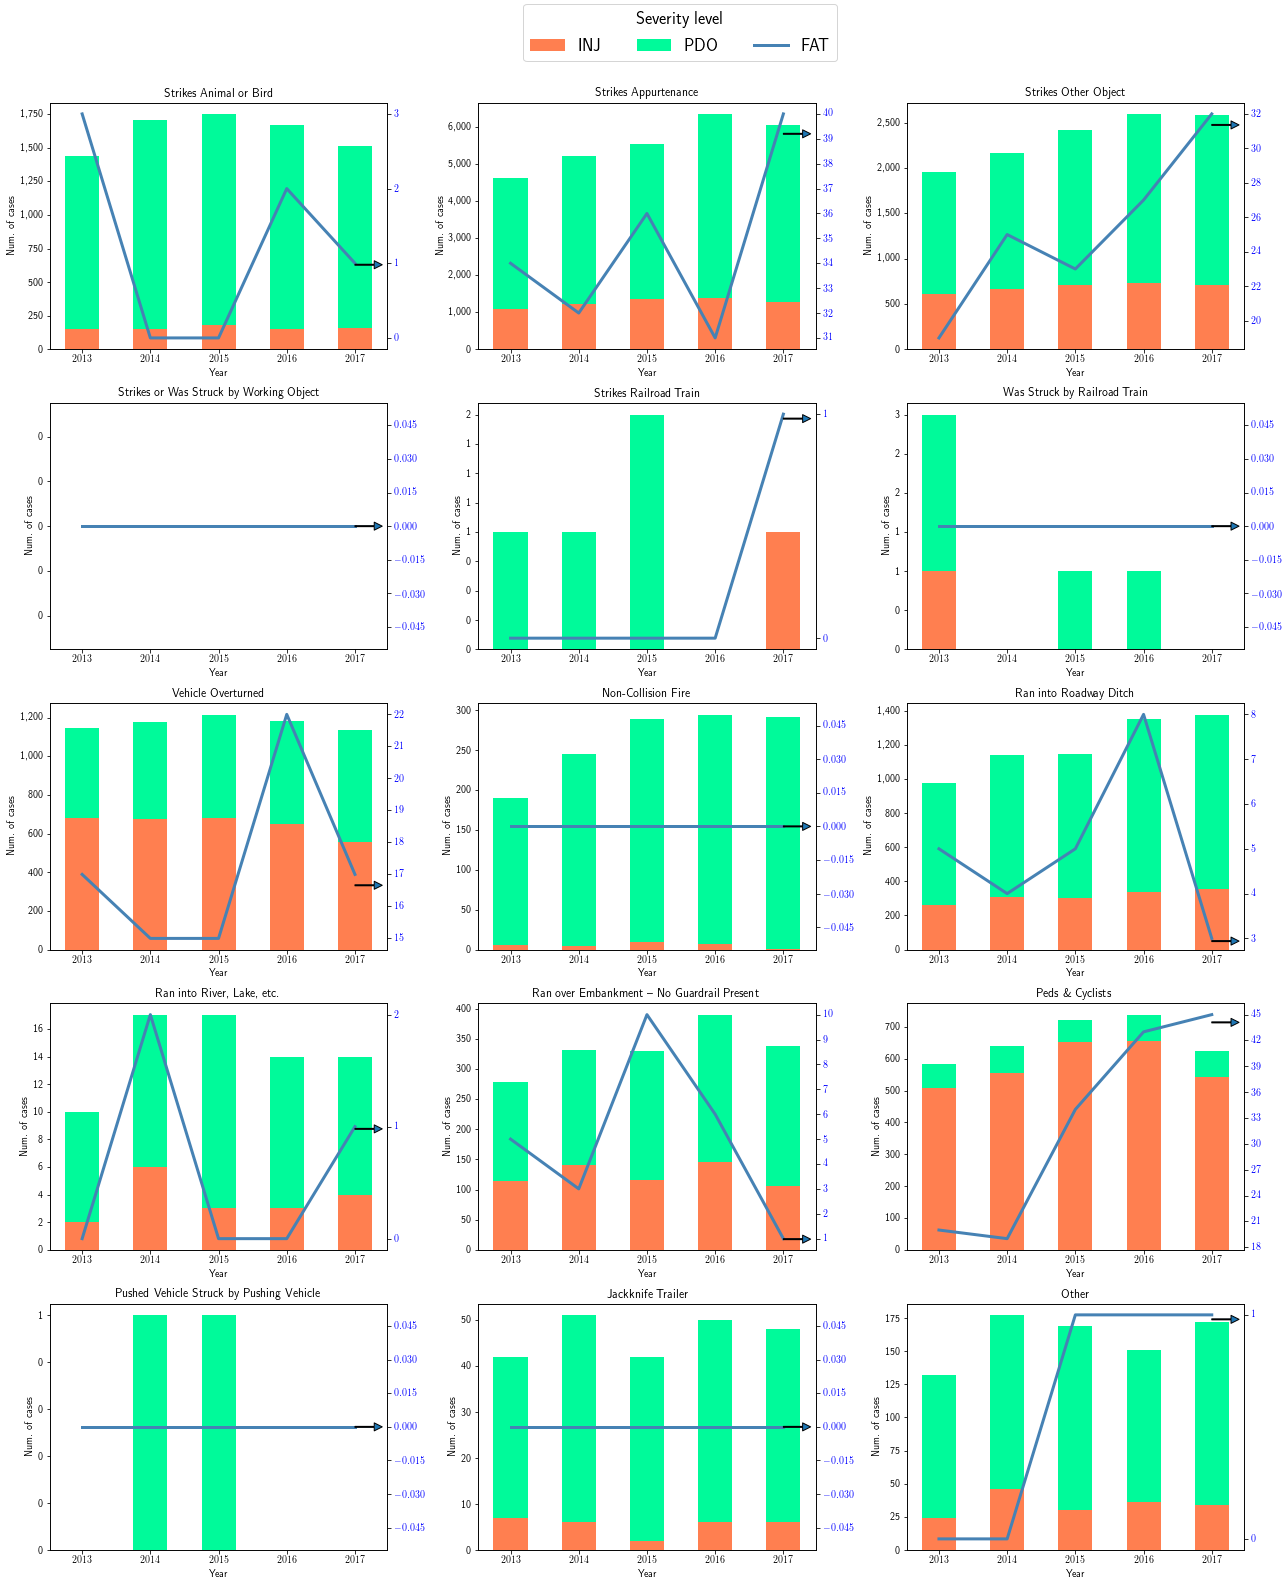

In [16]:
fig, axes = plt.subplots(5,3, figsize=(18,21))

nyear = 5
t = range(2013, 2013 + nyear)
for ind in range(len(acc_type_list) - 1): # 0,10
    s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    ax1, _ = two_scales(axes[ind//3][ind%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
    ax1.set_title('{}'.format(acc_type_list[ind]))

ind += 1
s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
ax1, _ = two_scales_with_legend(axes[ind//3][ind%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
ax1.set_title('{}'.format(acc_type_list[ind]))

fig.legend(
           # loc="upper center",   # Position of legend
           borderaxespad=0.3,    # Small spacing around legend box
           ncol=4,
           bbox_to_anchor=(0.65,1.05), 
           title="Severity level",  # Title for the legend
           fontsize="xx-large",title_fontsize="xx-large"
           )
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# plt.subplots_adjust(top = 0.8)
plt.tight_layout()
plt.show()

### Let's analyze #33 type: 
***Strikes Appurtenance***<br>
Find something interesting in this old topic. Looking at one vehicle accidents reduces the possible impact of human factors, which is unmodellable.

In [17]:
fat_target = [df[33] for df in fat]
inj_target = [df[33] for df in inj]
pdo_target = [df[33] for df in pdo]

In [25]:
print("For each year:")
print("    Fatality: {}".format(fat_target))
print("    Injury: {}".format(inj_target))
print("    Property-damage only: {}".format(pdo_target))

For each year:
    Fatality: [34, 32, 36, 31, 40]
    Injury: [1094, 1211, 1343, 1378, 1262]
    Property-damage only: [3536, 4008, 4212, 4964, 4801]


In [24]:
print(r"Total from 2013 - 2017: ")
print("    Fatality: {}".format(sum(fat_target)))
print("    Injury: {}".format(sum(inj_target)))
print("    Property-damage only: {}".format(sum(pdo_target)))

Total from 2013 - 2017: 
    Fatality: 173
    Injury: 6288
    Property-damage only: 21521
